# Análise do desempenho do modelo de detecção de violência

[Voltar ao Índice](00_indice.ipynb)

Nosso objetivo é verificar se o modelo de IA utilizado neste projeto está estimando corretamente os níveis de violência e se essa estimativa é adequada para diversos grupos sociais e tipos de violência.
Para tanto, vamos utilizar novas anotações de tweets feitas por parceiros.

**ATTENTION:** This notebook uses data that is not available in this project due to legal restrictions by the Brazilian Personal Data Protection Law ([LGPD](https://www.planalto.gov.br/ccivil_03/_ato2015-2018/2018/lei/l13709.htm)).

In [1]:
import pandas as pd
import matplotlib.pyplot as pl
import numpy as np
from glob import glob
from functools import partial
from multiprocessing import Pool
from importlib import reload
from pathlib import Path
import matplotlib.lines as mlines


import src.tweet_analysis as com
import src.analysis_functions as af
import src.xavy.dataframes as xd
import src.xavy.drive as dr
import src.xavy.stats as xs
import src.xavy.plots as xp
import src.xavy.mltools as ml
import src.xavy.utils as xu

**ATENÇÃO:** É preciso eliminar a contagem dupla caso dois anotadores sejam a mesma pessoa.

## Carregando classificações feitas pela máquina

In [23]:
# Lista arquivos a serem anotados por cada grupo, ainda vazios:
sample_files = glob('../dados/processados/amostra_tweets_para_anotacao_*.csv') # Dados não criptografados.
sample_files = list(filter(lambda s: s.find('encrypted') == -1, sample_files))
#sample_files = glob('../dados/processados/amostra_tweets_para_anotacao_*_encrypted.csv')

In [24]:
# Carrega IDs do tweets de cada grupo:
sampled_tweets_raw_df = pd.concat([af.load_group_data(f) for f in sample_files], ignore_index=True)

In [25]:
# Contabiliza grupos que foram alocados a cada tweet:
sampled_tweets_raw_df['n'] = 1
sampled_tweets_df = sampled_tweets_raw_df.pivot_table(index='id', columns='grupo', values='n', aggfunc='sum').fillna(0).astype(int)
sampled_tweets_df['n_grupos'] = sampled_tweets_df.sum(axis=1)

In [26]:
# Núm. de tweets no bin de score na amostra original:
sampled_bin_counts = sampled_tweets_raw_df.groupby('id')['n_prob_bin'].max()

In [27]:
# Carrega os tweets:
reload_tweets = False
tweet_selection_file = '../dados/processados/amostra_tweets_escolhidos_para_anotacao.csv' # Dados não criptografados.
#tweet_selection_file = '../dados/processados/amostra_tweets_escolhidos_para_anotacao_encrypted.csv'

if reload_tweets is True:
    # Carrega as configurações:
    config = com.read_config()

    # Load tweets:
    #tweets_df = com.etl_tweets_df(config['scored_tweets_dir'], config['target_model'], config['bad_users']) # Dados não criptografados.
    xz.sync_remote_zipped_files('https://nuvem.ceweb.br/s/EykWP7xR4msekxq/download/encrypted-scored-tweets.zip', '../tweets/', keep_zip_dir=False)
    tweets_df = com.etl_tweets_df('../tweets/encrypted/', config['target_model'], config['bad_users'])
    # Filter tweets directed to a single person:
    direct_df = com.select_direct_text_tweets(tweets_df)

    # Select tweets that were chosen for annotation:
    tweet_cols = ['id', 'created_at', 'text', 'tweet_url', 'direct_reply', 'batch_user', 'hate_score', 'target_prob']
    tweets4annotation_df = direct_df.loc[direct_df['id'].isin(sampled_tweets_df.index), tweet_cols]
    
    # Salva os tweets selecionados, para evitar ter que carregar tudo de novo:
    #tweets4annotation_df.to_csv(Path(tweet_selection_file), index=False)

else:
    # Carrega tweets já selecionados:
    tweets4annotation_df = pd.read_csv(Path(tweet_selection_file))

assert xd.iskeyQ(tweets4annotation_df[['id']])

## Carregando e preparando as anotações feitas

Para podermos carregar uma planilha do google sheets diretamente, precisamos que ela dê acesso ao seguinte usuário:
 `violentometro-sheets@ceweb-xavier.iam.gserviceaccount.com`

In [28]:
# Atualiza a lista de sheets com anotações a partir do Google Sheets:
#dir_file = '../dados/brutos/aux/tabela_planilhas_tweets_anotados.csv'
dir_file = '../dados/brutos/aux/tabela_planilhas_tweets_anotados_pseudonimo.csv'
dir_df = dr.load_data_from_local_or_drive('https://docs.google.com/spreadsheets/d/1C_eDa4JUcSuKXNJ8c5cI_3aOSMiDlX-hRsVz71WUZz4', dir_file, force_drive=False)
print(xd.bold('Repetição de anotadores'))
xd.check_guarda_compartilhada(dir_df, 'Responsável', 'Anotador')

Loading data from local file...
Repetição de anotadores


Responsável
Xandi    [A06, A09, A10, A13]
Name: Anotador, dtype: object

In [29]:
ignore_annotators = ['A13']

# Junta as anotações aos tweets:
tweets_annotated_df = tweets4annotation_df
for grupo in dir_df['Grupo'].drop_duplicates():
    print('* Grupo: {}'.format(grupo))
    # Carrega dados de cada anotador dentro de um grupo social:
    path_template = '../dados/brutos/eletweet22/tweets_anotados_{}_{}.csv'           # Dados não criptografados.
    df = af.etl_group_annotations(dir_df, grupo, path_template, force_drive=False)
    tweets_annotated_df = tweets_annotated_df.join(df, how='outer', on='id')

n_unmatched = tweets_annotated_df['created_at'].isnull().sum()
assert n_unmatched == 0, 'Tivemos {} anotacoes que não foram associadas a nenhum tweet.'.format(n_unmatched)

# Calcula a categoria final depois de usar majority voting 
af.summarize_annotations(tweets_annotated_df, ignore_annotators=ignore_annotators, defaults=[0, 0, 0, 0, 0])

# Verifica se dados estão OK:
print('')
af.security_checks(tweets_annotated_df)

tweets_annotated_df = tweets_annotated_df.join(sampled_tweets_df, on='id')

* Grupo: Pessoas negras
Loading data from local file...
Loading data from local file...
Loading data from local file...
Loading data from local file...
* Grupo: Mulheres
Loading data from local file...
Loading data from local file...
Loading data from local file...
* Grupo: LGBTs
Loading data from local file...
Loading data from local file...
Loading data from local file...
* Grupo: Controle
Loading data from local file...
Loading data from local file...
Loading data from local file...

!! Os seguintes tweets não possuem o mesmo número de anotações em todas as categorias: {674, 579, 644, 743, 1019, 1191, 237, 1198, 559, 787, 693, 86, 917, 88, 1430, 731, 412, 574}


In [34]:
tweets_annotated_df.sample(4).transpose()

,848,114,442,546
id,1568706505490268161,1560977803536891907,1564340922980106241,1565394290443960320
created_at,2022-09-10 18:02:30-03:00,2022-08-20 10:11:24-03:00,2022-08-29 16:55:14-03:00,2022-09-01 14:40:57-03:00
text,Que é isso que aconteceu com a camarada @Benny...,@lidicedamata @LulaOficial Ó coitada 🤭😂😂😂😂,"@samanthacavalca E quem é vc realmente,uma pes...",@GMonteiroRJ Mano me desculpa mais você é um m...
tweet_url,https://www.twitter.com/VietCauang/status/1568...,https://www.twitter.com/aronvrl/status/1560977...,https://www.twitter.com/CarlosE46781451/status...,https://www.twitter.com/Francis22755773/status...
direct_reply,0,1,1,1
...,...,...,...,...
controle,0,0,0,0
lgbts,1,0,0,0
mulheres,0,0,1,0
pessoas_negras,0,1,0,1


In [36]:
# Salva a tabela com as anotações agrupadas e as estatísticas de cada tweet:
#tweets_annotated_df.to_csv('../dados/processados/eletweet22_tweets-anotados.csv', index=False)

In [30]:
for col in af.find_cols(tweets_annotated_df, 'cand_objeto_A'):
    print(col, tweets_annotated_df[col].unique())

cand_objeto_A01 [nan  1.  0.]
cand_objeto_A02 [nan  1.  0.]
cand_objeto_A03 [nan  1.  0.]
cand_objeto_A13 [nan  1.  0.]
cand_objeto_A04 [ 1. nan  0.]
cand_objeto_A05 [ 0. nan  1.]
cand_objeto_A06 [ 1. nan  0.]
cand_objeto_A07 [nan  1.  0.]
cand_objeto_A08 [nan  1.  0.]
cand_objeto_A09 [nan  1.  0.]
cand_objeto_A10 [nan  1.  0.]
cand_objeto_A11 [nan]
cand_objeto_A12 [nan]


### Estatísticas das anotações

In [31]:
# Contabiliza as anotações para acompanhar o trabalho dos anotadores:
af.count_annotations_made(tweets_annotated_df)

label,cand_objeto,lgbtfobico,machista,racista,violento
anotador,,,,,
A01,393,389,393,393,393
A02,394,394,394,394,395
A03,400,400,400,399,400
A04,400,399,400,400,400
A05,400,400,400,400,400
A06,400,400,400,400,400
A07,396,398,398,398,398
A08,397,397,396,395,398
A09,400,400,400,400,400


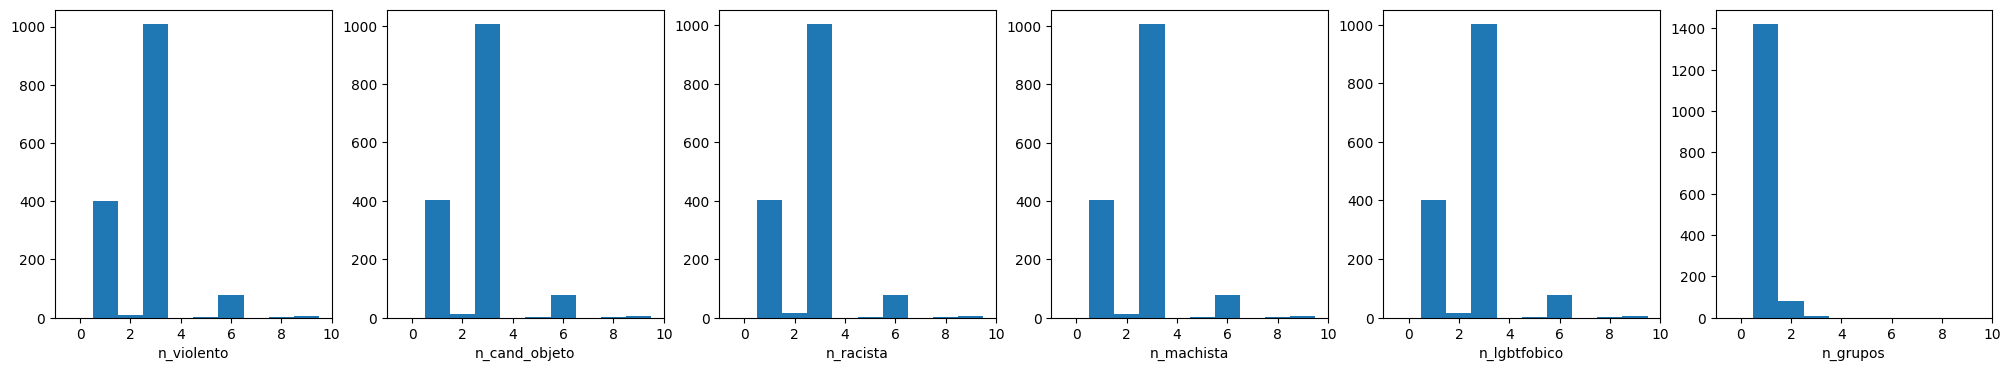

In [32]:
# Número de tweets com cada número de anotações feitas:
count_cols = af.find_cols(tweets_annotated_df, 'n_')
pl.figure(figsize=(25,4))
for i, col in enumerate(count_cols):
    pl.subplot(1, len(count_cols), i + 1)
    pl.hist(tweets_annotated_df[col], bins=np.arange(-0.5, 10.5, 1))
    pl.xlabel(col)
pl.show()

In [10]:
xd.print_string_series(tweets_annotated_df.query('cand_objeto_final == 0 and violento_final == 0').sample(3, random_state=3)['tweet_url'])

51: https://www.twitter.com/well11sp/status/1560283460576624641
664: https://www.twitter.com/MarliCella/status/1566483908652408834
1224: https://www.twitter.com/Kelly78637956/status/1574168831001436160


In [11]:
tweets_annotated_df['n_violento'].value_counts().sort_index()

1     402
2      10
3    1008
5       1
6      77
8       1
9       7
Name: n_violento, dtype: int64

In [13]:
len(tweets_annotated_df.query('n_violento >= 3'))

1094

## Concordância entre anotadores

### Fleiss' Kappa

In [9]:
def compute_kappa(df):
    kappa = xs.fleiss_kappa(df.astype(int).values, N_classes=2, n_votes_per_class=False)
    return kappa

def get_random_kappa(seed, df):
    return compute_kappa(xs.break_column_correlations(df, seed))

def plot_agreement_report(dir_df, tweets_df, grupo, campo, min_tweets=100, n_kappa_samples=4000, seed0=35):
    
    # Seleciona anotações:
    anotadores = dir_df.query('Grupo == "{}"'.format(grupo))['Anotador']
    cols = campo + '_' + anotadores
    n_tweets = (~tweets_df[cols].isnull()).sum()
    good_anotators = n_tweets.loc[n_tweets > min_tweets]
    X = tweets_df.loc[~tweets_df[good_anotators.index].isnull().any(axis=1), good_anotators.index]

    # Calcula concordância entre eles:
    kappa = compute_kappa(X)

    # Create a sample of kappas for randomly tagged tweets:
    with Pool() as pool:
        seeds = list(range(seed0, seed0 + n_kappa_samples))
        rand_kappas = pool.map(partial(get_random_kappa, df=X), seeds) 
    #rand_kappas = np.array([get_random_kappa(i + seed0, X) for i in range(n_kappa_samples)])

    # Cria histograma :
    pl.hist(rand_kappas)
    ax = pl.gca()
    anot_counts = good_anotators.rename(dict(zip(cols, anotadores)))
    pl.text(0.95, 0.95, '# anotações:\n{}\n\nK: {:.3f}'.format(anot_counts, kappa), transform=ax.transAxes, va='top', ha='right')
    pl.xlabel('Kappa aleatório')
    pl.ylabel('# amostras')
    pl.title(campo + ' - ' + grupo)

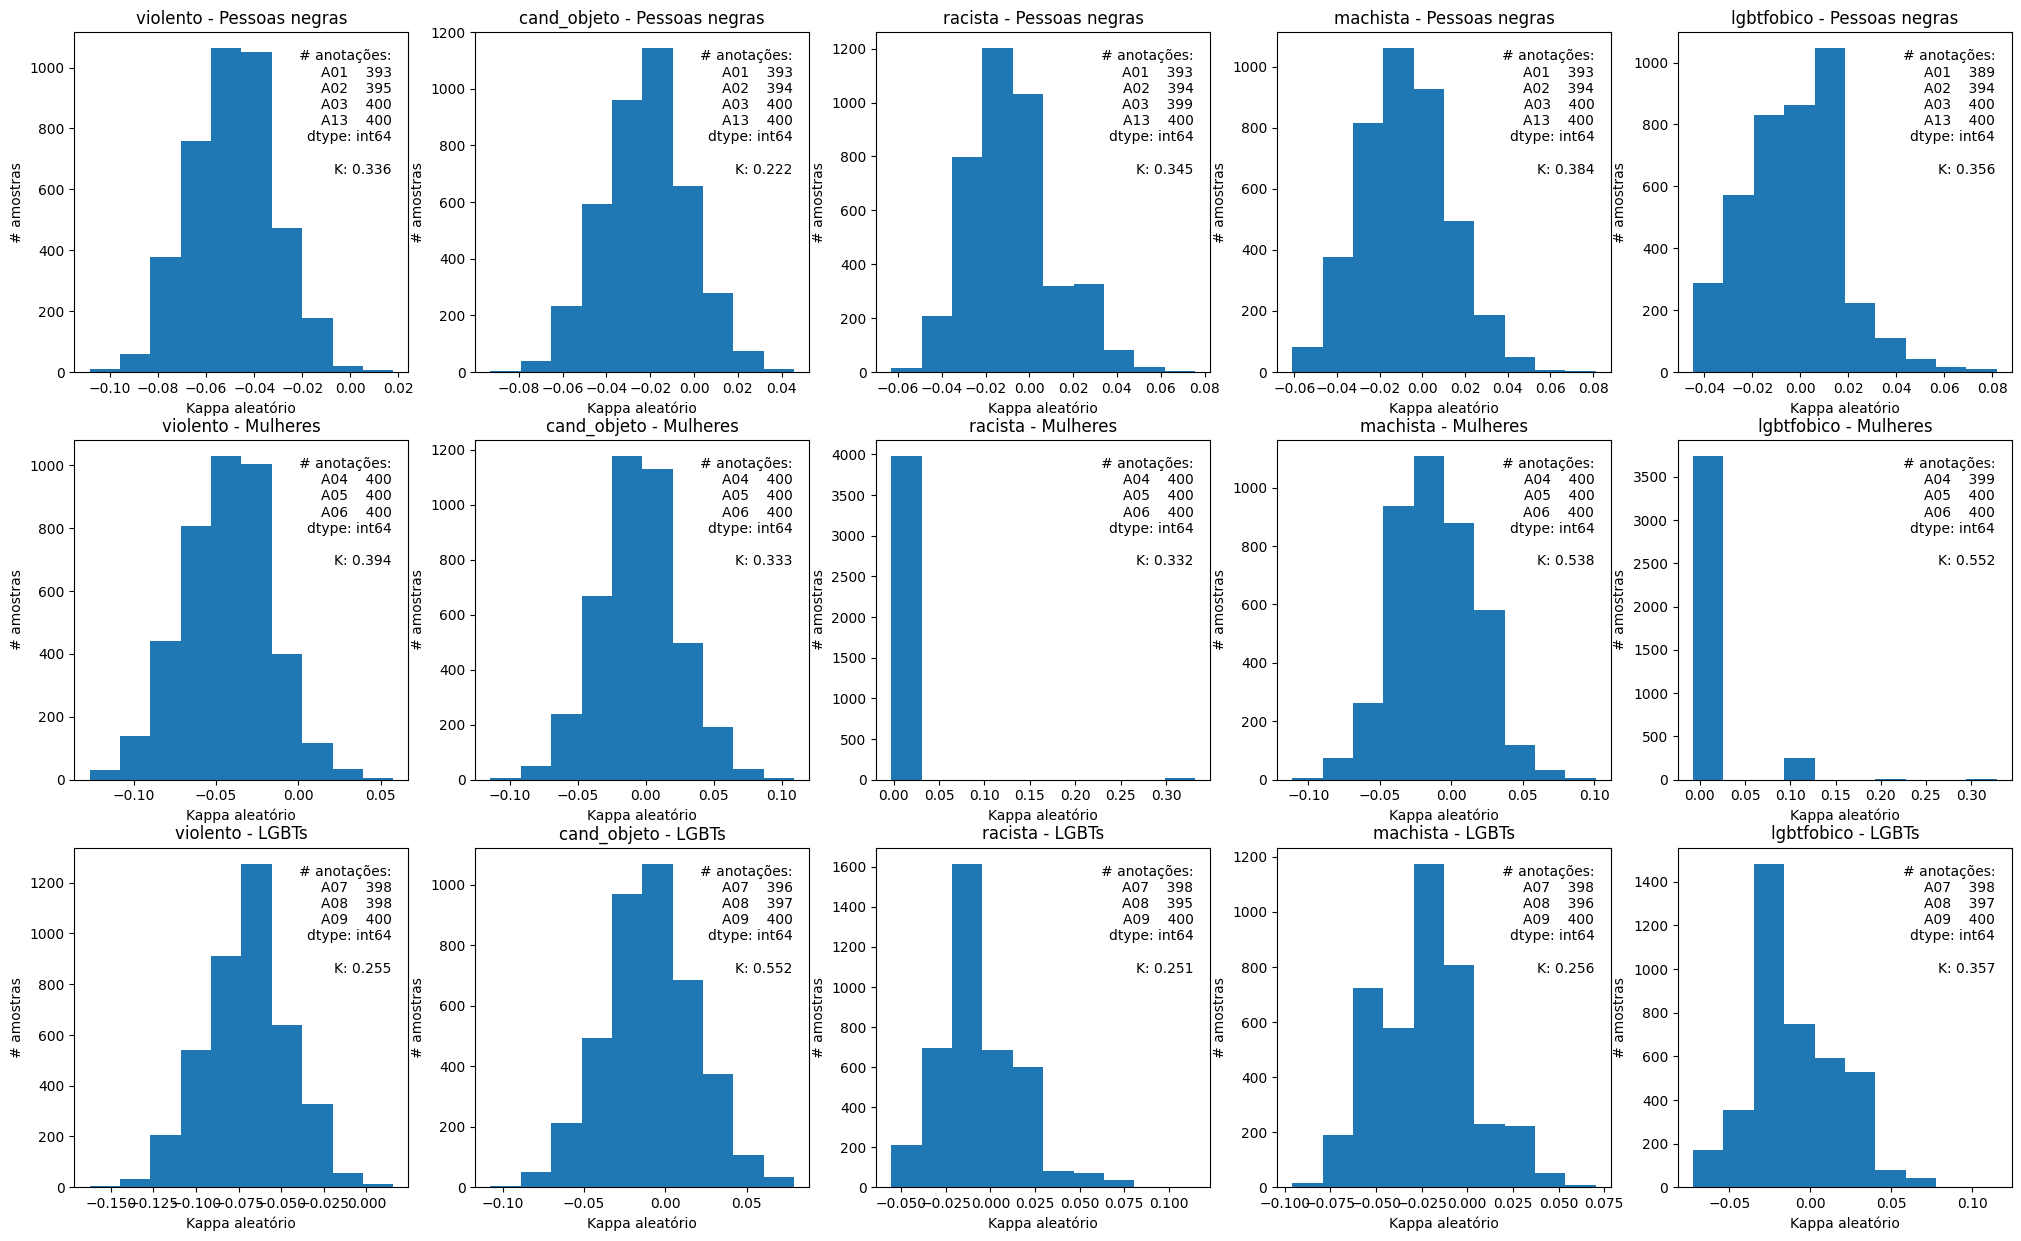

In [10]:
grupos = ['Pessoas negras', 'Mulheres', 'LGBTs']
campos = ['violento', 'cand_objeto', 'racista', 'machista', 'lgbtfobico']

n_campos = len(campos)
n_grupos = len(grupos)
pl.figure(figsize=(5 * n_campos, 5 * n_grupos))
for i, grupo in enumerate(grupos):
    for j, campo in enumerate(campos):
        pl.subplot(n_grupos, n_campos, 1 + j + i * n_campos)
        plot_agreement_report(dir_df, tweets_annotated_df, grupo, campo)


### Matriz de concordância

In [256]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Sepeciona anotações de interesse:
annotations_df = tweets_annotated_df[af.find_cols(tweets_annotated_df, 'violento_A')].drop(['violento_A10', 'violento_A11', 'violento_A12'], axis=1).dropna(how='all')
# Renomeia anotadores igual ao artigo:
paper_names    = annotations_df.columns.str.split('_').str.slice(-1).str.join('').map(xu.translate_dict({'A13':'A10', 'A06':'A10', 'A09':'A10'}))

def annotation_matrix_show(df, cmap, label, vmin=None):
    
    pl.matshow(df, cmap=cmap, vmin=vmin)
    pl.xticks(ticks=range(len(paper_names)), labels=paper_names)
    pl.yticks(ticks=range(len(paper_names)), labels=paper_names)
    pl.axvline(3.5, color='k')
    pl.axvline(6.5, color='k')
    pl.axhline(3.5, color='k')
    pl.axhline(6.5, color='k')
    ax = pl.gca()
    pl.tick_params(labelsize=10)
    pl.xlabel('    Pessoas negras        Mulheres            LGBTs', loc='left')
    ax.xaxis.set_label_position('top')
    pl.ylabel('        LGBTs           Mulheres        Pessoas negras', loc='bottom')

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = pl.colorbar(cax=cax)
    cbar.ax.tick_params(labelsize=10)
    cbar.ax.set_ylabel(label, fontsize=11)

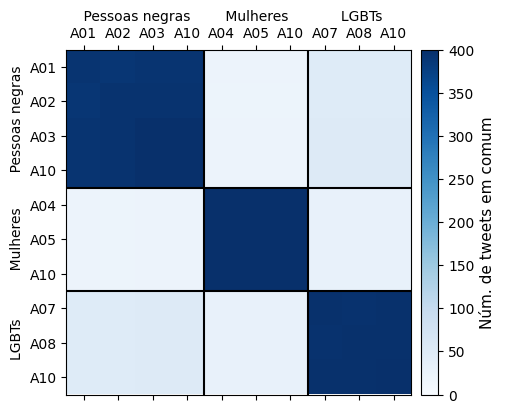

In [259]:
# Número de tweets anotados em comum:
exist_df = (~annotations_df.isnull()).astype(int)
common_anot_df = pd.DataFrame()
for c1 in exist_df.columns:
    for c2 in exist_df.columns:
        common_anot_df.loc[c1, c2] = (exist_df[c1] * exist_df[c2]).sum()

annotation_matrix_show(common_anot_df, 'Blues', 'Núm. de tweets em comum', vmin=0)

#pl.savefig(Path('../resultados/plots/anotadores_matriz_n-comum.eps'), bbox_inches='tight')
#pl.savefig(Path('../resultados/plots/anotadores_matriz_n-comum.png'), bbox_inches='tight')
pl.show()

In [ ]:
# Fração de anotações iguais:
acc_df = pd.DataFrame()
for c1 in annotations_df.columns:
    for c2 in annotations_df.columns:
        pair_df = annotations_df[[c1, c2]].dropna(how='any')
        acc_df.loc[c1, c2] = accuracy_score(pair_df[c1], pair_df[c2])
        #acc_df.loc[c1, c2] = xs.fleiss_kappa(pair_df.astype(int).values, N_classes=2, n_votes_per_class=False)

#for c1 in acc_df.columns:
#    acc_df.loc[c1, c1] = np.NaN

#acc_df.where(common_anot_df > 100, np.NaN, inplace=True)

annotation_matrix_show(acc_df * 100, 'Greens', '% de concordância')

#pl.savefig(Path('../resultados/plots/anotadores_matriz_concordancia_block-diag.eps'), bbox_inches='tight')
#pl.savefig(Path('../resultados/plots/anotadores_matriz_concordancia_block-diag.png'), bbox_inches='tight')
pl.show()

In [283]:
acc_df * 100

,violento_A01,violento_A02,violento_A03,violento_A13,violento_A04,violento_A05,violento_A06,violento_A07,violento_A08,violento_A09
violento_A01,100.000000,52.820513,83.715013,58.269720,54.545455,90.909091,72.727273,85.714286,67.346939,55.102041
violento_A02,52.820513,100.000000,62.025316,77.721519,80.952381,76.190476,80.952381,42.857143,75.510204,79.591837
violento_A03,83.715013,62.025316,100.000000,66.000000,54.545455,81.818182,72.727273,70.000000,74.000000,70.000000
violento_A13,58.269720,77.721519,66.000000,100.000000,72.727273,81.818182,90.909091,60.000000,80.000000,84.000000
violento_A04,54.545455,80.952381,54.545455,72.727273,100.000000,66.000000,79.000000,46.666667,80.000000,86.666667
violento_A05,90.909091,76.190476,81.818182,81.818182,66.000000,100.000000,69.500000,73.333333,66.666667,80.000000
violento_A06,72.727273,80.952381,72.727273,90.909091,79.000000,69.500000,100.000000,56.666667,83.333333,96.666667
violento_A07,85.714286,42.857143,70.000000,60.000000,46.666667,73.333333,56.666667,100.000000,63.383838,61.055276
violento_A08,67.346939,75.510204,74.000000,80.000000,80.000000,66.666667,83.333333,63.383838,100.000000,82.914573
violento_A09,55.102041,79.591837,70.000000,84.000000,86.666667,80.000000,96.666667,61.055276,82.914573,100.000000


In [217]:
# % de concordância esperada no chute (aprox.):
ratings = tweets_annotated_df.query('controle == 0')['violento_final'].dropna()
accuracy_score(ratings, xs.shuffle_data(ratings))

0.4972875226039783

In [263]:
common_anot_df

,violento_A01,violento_A02,violento_A03,violento_A13,violento_A04,violento_A05,violento_A06,violento_A07,violento_A08,violento_A09
violento_A01,393.0,390.0,393.0,393.0,22.0,22.0,22.0,49.0,49.0,49.0
violento_A02,390.0,395.0,395.0,395.0,21.0,21.0,21.0,49.0,49.0,49.0
violento_A03,393.0,395.0,400.0,400.0,22.0,22.0,22.0,50.0,50.0,50.0
violento_A13,393.0,395.0,400.0,400.0,22.0,22.0,22.0,50.0,50.0,50.0
violento_A04,22.0,21.0,22.0,22.0,400.0,400.0,400.0,30.0,30.0,30.0
violento_A05,22.0,21.0,22.0,22.0,400.0,400.0,400.0,30.0,30.0,30.0
violento_A06,22.0,21.0,22.0,22.0,400.0,400.0,400.0,30.0,30.0,30.0
violento_A07,49.0,49.0,50.0,50.0,30.0,30.0,30.0,398.0,396.0,398.0
violento_A08,49.0,49.0,50.0,50.0,30.0,30.0,30.0,396.0,398.0,398.0
violento_A09,49.0,49.0,50.0,50.0,30.0,30.0,30.0,398.0,398.0,400.0


In [322]:
# Exportando exemplos de tweets anotados por todos:
fully_annotated_df = tweets_annotated_df.loc[tweets_annotated_df['n_violento'] >= 9]
n_violent = fully_annotated_df[af.find_cols(tweets_annotated_df, 'violento_A')].drop(['violento_A06', 'violento_A09'], axis=1).sum(axis=1)
n_violent.name = 'n_concorda'
#fully_annotated_df[['text', 'hate_score']].join(n_violent, how='inner').sort_values('n_concorda').to_csv(Path('../resultados/tweets_completamente-anotados_violencia.csv'), index=False)

### Relação com anotador controle

In [11]:
from sklearn.metrics import confusion_matrix

In [12]:
def show_confusion_matrix(tweets_df, campo, a1, a2, normalize=None):
    
    cols = [campo + '_' + a1, campo + '_' + a2]
    data_df = tweets_df.loc[~tweets_df[cols].isnull().any(axis=1), cols]
    X = confusion_matrix(data_df[cols[0]], data_df[cols[1]], normalize=normalize)
    if len(X) == 0:
        X = np.array([[np.NaN, np.NaN], [np.NaN, np.NaN]])
    cm_df = pd.DataFrame(data=X, index=[a1 + ': Não', a1 + ': Sim'], columns=[a2 + ': Não', a2 + ': Sim'])
    cm_df.style.set_caption(campo)
    return cm_df

def std_confusion_matrix(tweets_df, campo, a1, a2, normalize=None):
    return show_confusion_matrix(tweets_df, campo, a1, a2, normalize=normalize).set_index(np.array(['Controle: Não', 'Controle: Sim']))

In [25]:
controle = dir_df.loc[dir_df['Responsável'].fillna('').str.contains('^X', regex=True)].set_index('Grupo')['Anotador']
controle.name = 'Controle'
anotadores_pairs_df = dir_df.loc[~dir_df['Responsável'].fillna('').str.contains('^X', regex=True)].set_index('Grupo')[['Anotador']].join(controle)

In [36]:
campo = 'violento'
sigma_list = []
for campo in campos:
    print(xd.bold(campo))
    cm_dfs = []
    for grupo in grupos:
        sel_pair_df = anotadores_pairs_df.query('Grupo == "{}"'.format(grupo))
        for a1, a2 in zip(sel_pair_df['Controle'], sel_pair_df['Anotador']):
            cm = std_confusion_matrix(tweets_annotated_df, campo, a1, a2, normalize='all')
            cm_dfs.append(cm)
            
            anotador = cm.columns[0].split(':')[0]
            n_sigma  = (cm.iloc[0,1] - cm.iloc[1,0]) / np.sqrt(cm.iloc[0,1] + cm.iloc[1,0])
            sigma_list.append({'campo': campo, 'anotador': anotador, 'n_sigma':n_sigma})

    confusion_df = pd.concat(cm_dfs, axis=1)
    display(confusion_df)

violento


,A01: Não,A01: Sim,A02: Não,A02: Sim,A03: Não,A03: Sim,A04: Não,A04: Sim,A05: Não,A05: Sim,A07: Não,A07: Sim,A08: Não,A08: Sim
Controle: Não,0.254453,0.407125,0.579747,0.083544,0.3475,0.3150,0.6175,0.0925,0.4125,0.2975,0.462312,0.384422,0.741206,0.105528
Controle: Sim,0.010178,0.328244,0.139241,0.197468,0.0250,0.3125,0.1175,0.1725,0.0075,0.2825,0.005025,0.148241,0.065327,0.087940


cand_objeto


,A01: Não,A01: Sim,A02: Não,A02: Sim,A03: Não,A03: Sim,A04: Não,A04: Sim,A05: Não,A05: Sim,A07: Não,A07: Sim,A08: Não,A08: Sim
Controle: Não,0.066158,0.290076,0.276650,0.076142,0.2425,0.1175,0.4300,0.0375,0.2675,0.20,0.373737,0.088384,0.435768,0.027708
Controle: Sim,0.089059,0.554707,0.152284,0.494924,0.2425,0.3975,0.1575,0.3750,0.2225,0.31,0.111111,0.426768,0.183879,0.352645


racista


,A01: Não,A01: Sim,A02: Não,A02: Sim,A03: Não,A03: Sim,A04: Não,A04: Sim,A05: Não,A05: Sim,A07: Não,A07: Sim,A08: Não,A08: Sim
Controle: Não,0.928753,0.050891,0.946701,0.032995,0.887218,0.092732,0.995,0.0025,0.9975,0.0,0.904523,0.080402,0.939241,0.045570
Controle: Sim,0.007634,0.012723,0.015228,0.005076,0.002506,0.017544,0.000,0.0025,0.0025,0.0,0.005025,0.010050,0.010127,0.005063


machista


,A01: Não,A01: Sim,A02: Não,A02: Sim,A03: Não,A03: Sim,A04: Não,A04: Sim,A05: Não,A05: Sim,A07: Não,A07: Sim,A08: Não,A08: Sim
Controle: Não,0.865140,0.083969,0.913706,0.035533,0.8200,0.1300,0.8375,0.0475,0.7375,0.1475,0.826633,0.155779,0.898990,0.083333
Controle: Sim,0.017812,0.033079,0.015228,0.035533,0.0075,0.0425,0.0300,0.0850,0.0175,0.0975,0.002513,0.015075,0.005051,0.012626


lgbtfobico


,A01: Não,A01: Sim,A02: Não,A02: Sim,A03: Não,A03: Sim,A04: Não,A04: Sim,A05: Não,A05: Sim,A07: Não,A07: Sim,A08: Não,A08: Sim
Controle: Não,0.928021,0.048843,0.956853,0.020305,0.9425,0.0325,0.987469,0.002506,0.9850,0.0025,0.886935,0.090452,0.929471,0.047859
Controle: Sim,0.005141,0.017995,0.007614,0.015228,0.0150,0.0100,0.007519,0.002506,0.0075,0.0050,0.000000,0.022613,0.005038,0.017632


In [18]:
sigma_df = pd.DataFrame(sigma_list)
sigma_df['abs_n_sigma'] = np.abs(sigma_df['n_sigma'])
sigma_df = sigma_df.sort_values('abs_n_sigma', ascending=False)
sigma_df.query('abs_n_sigma >= 0 and campo == "violento"')

,campo,anotador,n_sigma,abs_n_sigma
0,violento,A01,0.614478,0.614478
5,violento,A07,0.607952,0.607952
4,violento,A05,0.525107,0.525107
2,violento,A03,0.497346,0.497346
1,violento,A02,-0.118000,0.118000
6,violento,A08,0.097258,0.097258
3,violento,A04,-0.054554,0.054554


In [28]:
campo = 'racista'
anotador = 'A01'
row = anotadores_pairs_df.query('Anotador == "{}"'.format(anotador)).iloc[0]
print(row)
query0 = '({0}_{1} == 1 and {0}_{2} == 0)'
query1 = '({0}_{1} == 0 and {0}_{2} == 1)'
sel0 = tweets_annotated_df.query(query0.format(campo, row['Controle'], row['Anotador'])).set_index('tweet_url')['text']
print(xd.bold('Anotador não marcou ({})'.format(len(sel0))))
xd.print_string_series(sel0.sample(min(10, len(sel0))))
sel1 = tweets_annotated_df.query(query1.format(campo, row['Controle'], row['Anotador'])).set_index('tweet_url')['text']
print(xd.bold('Controle não marcou ({})'.format(len(sel1))))
xd.print_string_series(sel1.sample(min(10, len(sel1))))

Anotador    A01
Controle    A13
Name: Pessoas negras, dtype: object
Anotador não marcou (3)
https://www.twitter.com/Bruno__Rogers/status/1573345741719879680: @danimontpsol O povo estava com toda razão. Lixo deve ser jogado fora mesmo. Sem pena. 

O RJ é 100% bolsonarista mermão. Quem não aceita isso é esquerdista fracassado.
https://www.twitter.com/xarope_bolado/status/1567979648956481538: @beatrizcaminha Por isso que me dá uma raiva tremenda quando alguém vem com esse papo de "ah,extermínio da população negra",mimimi...me poupe!!!!Eu sou NEGÃO,p...,não coitadinho,nem vitiminha,nem escravinho!!!!Ah,e GOD SAVE THE QUEEN!!!!REST IN PEACE!!!!!!!!!!
https://www.twitter.com/Jed_KapIan/status/1574472401269788680: @renatasouzario Kkkkk vai lá defensora dos traficantes fracos e oprimidos
Controle não marcou (20)
https://www.twitter.com/Hellephant2/status/1568215733213036545: @southaferreira Mimimi racismo imperialismo, enquanto isso faz parte de um partido comunista, ideologia responsável por 

#### Anotações sobre violências específicas

In [22]:
test_df = tweets_annotated_df.query('controle == 0')
for v in ['racista_final', 'machista_final', 'lgbtfobico_final']:
    print(v, test_df[v].sum())

racista_final 26.0
machista_final 99.0
lgbtfobico_final 31.0


### Exemplos de violências específicas

In [158]:
n_check = tweets_annotated_df.loc[:, ['lgbtfobico_A07', 'lgbtfobico_A08', 'lgbtfobico_A09']].dropna().sum(axis=1)
n_check.name = 'n_lgbtfobico'
sel = tweets_annotated_df[['text', 'tweet_url']].join(n_check, how='inner')
togo = sel.groupby('n_lgbtfobico').sample(2, random_state=57)
#togo.to_csv(Path('../resultados/tweets-anotados3_lgbtfobia.csv'))

In [156]:
n_check = tweets_annotated_df.loc[:, ['machista_A04', 'machista_A05', 'machista_A05']].dropna().sum(axis=1)
n_check.name = 'n_machista'
sel = tweets_annotated_df[['text', 'tweet_url']].join(n_check, how='inner')
togo = sel.groupby('n_machista').sample(2, random_state=57)
#togo.to_csv(Path('../resultados/tweets-anotados3_machismo.csv'))

In [14]:
n_check = tweets_annotated_df.loc[:, ['racista_A01', 'racista_A02', 'racista_A03', 'racista_A13']].dropna().sum(axis=1)
n_check.name = 'n_racista'
sel = tweets_annotated_df[['text', 'tweet_url']].join(n_check, how='inner')
togo = sel.groupby('n_racista').sample(2, random_state=57)
#togo.to_csv(Path('../resultados/tweets-anotados4_racismo.csv'))

In [23]:
togo.loc[1062]['tweet_url']

'https://www.twitter.com/Josipadilha3/status/1572367871912865793'

In [25]:
tweets_annotated_df.loc[tweets_annotated_df['text'].str.contains('Que absurdo! Que sujeito boçal!')]['violento_final']

1096    0.0
Name: violento_final, dtype: float64

In [163]:
tweets_annotated_df.loc[412][['cand_objeto_A07', 'cand_objeto_A08', 'cand_objeto_A09']]

cand_objeto_A07    NaN
cand_objeto_A08    1.0
cand_objeto_A09    0.0
Name: 412, dtype: object

In [159]:
xd.print_string_series(togo.set_index('tweet_url')['text'])

https://www.twitter.com/santajoyb/status/1575202675586498560: Vovó sem deputado estadual e eu “vamo de Vini” aí ela “sei não, nunca vi aqui na ilha” aí eu “ele tá com Lula” ela “tá, vou pensar” 
A realidade é que ngm lembra da Ilha do Maruim mesmo, hey @castelllovini bora mudar isso aí
https://www.twitter.com/dani88azevedo/status/1575915534415106049: @mariamarighella @jairmearrependi @lucinhadomst Minhas deputadas ❤️
https://www.twitter.com/PauloFarias2000/status/1564370973989666817: @ErikakHilton @ManuelaDavila Só as feias como vc.
https://www.twitter.com/AntiPTantiBozo/status/1571613262306746375: @fabiofelixdf Mamador do dinheiro publico!!! Fujão, covarde!
https://www.twitter.com/Leandro45100/status/1572038089110917121: @ErikakHilton Gostaria saber quantos idiota voto ser desse
https://www.twitter.com/andremaronga1/status/1564063427332657154: @fabiofelixdf Tá querendo falar grosso !! Kkkk mas tá mais perdida que tudo !!
https://www.twitter.com/DimPatriota/status/1576551871686197248: 

### Impacto do objeto na anotação

In [40]:
# Separando tweets por objeto:
test_df      = tweets_annotated_df.query('controle == 0')
terceiros_df = test_df.query('cand_objeto_final == 0')
direto_df    = test_df.query('cand_objeto_final == 1')

In [94]:
# Buscando palavras comuns:
xd.print_string_series(test_df.query('violento_final == 1 and cand_objeto_final == 0')['text'].sample(10))

866: @Biakicis Vagabundo
1308: @perpetua_acre Bando de “artistas” i interesseiros
790: @majorfabianadep Mais uma babaquice fake News feia do jornalismo lunático esquerdopata louco de plantão
42: @matheuspggomes Bolsonaristas são estúpidos e burros por natureza. Lula será eleito. Bolsonazi vai pra cadeia pagar pelos crimes cometidos. E os bolsominios,  cambada estúpida e naturalmente burra, voltarão para os esgotos fedorentos de onde saíram. Vai um chororô só.
924: @jessicamichels Minha hipótese é makumba. As regiões com mais aglomeração de makumbeiro tão cheia de pombo.
639: @fabiofelixdf Banda de merda !
734: @majorfabianadep Isto é vagabundagem deste malandro
1353: @apropriajulia Eu vou com camiseta amarela votar e fod@se o cabeça de piroc@
1428: @majorfabianadep @RomarioOnze Só  um drogado !!!
1489: @pastorhenriquev L de LEGIÃO https://t.co/0mrYBEYfQp


In [112]:
# Seleção por palavras comuns e contabilização por violência ou não:
regexes = [r'v[a4@]g[a4@]bund', r's[a4@]f[a4@]d', r'\b(?:bosta|merda)\b', r'r[1i]d[1ií][kc]ul[a@o]', r'nojent', r'\bnojo\b', r'ladr[ãa@]o', r'ment[1i]ros[ao]', 
           r'\b[ck](?:u|ool?)\b', r'canalha', r'bandid[ao]', r'\bburr[ao]|besta\b', r'piranha', r'carniça', r'lixo', r'p[@4a]lh[@4a][cç][a40@o]\b', r'm[@4a]l[@4a]ndr[ao40@]', r'est[uú]pid[oa]']
regexes = [r'v[a4@]g[a4@]bund']
norm = False
sel_direto    = direto_df.loc[direto_df['text'].str.contains('|'.join(regexes), case=False)]
sel_terceiros = terceiros_df.loc[terceiros_df['text'].str.contains('|'.join(regexes), case=False)]
print(xd.bold('Candidatura'))
print(sel_direto['violento_final'].value_counts(normalize=norm).sort_index())
print(xd.bold('Terceiros'))
print(sel_terceiros['violento_final'].value_counts(normalize=norm).sort_index())

Candidatura
0.0     2
1.0    20
Name: violento_final, dtype: int64
Terceiros
0.0     4
1.0    13
Name: violento_final, dtype: int64


In [113]:
print(xd.bold('Candidatura'))
print(sel_direto['hate_score'].mean())
print(xd.bold('Terceiros'))
print(sel_terceiros['hate_score'].mean())

Candidatura
0.6919999413636363
Terceiros
0.7059351764705883


In [114]:
# Exemplos:
print(xd.bold('Candidatura'))
xd.print_string_series(sel_direto.set_index('violento_final')['text'].sample(10))
print(xd.bold('Terceiros'))
xd.print_string_series(sel_terceiros.set_index('violento_final')['text'].sample(10))

Candidatura
1.0: @guimaraes13PT @ricardostuckert Esse vagabundo só quer nosso dinheiro.
1.0: @samiabomfim Aborto é ASSASSINATO sua vagabunda
0.0: @FernandoHoliday Concordo e votar no Bolsonaro é dar carta branca ao NEGACIONISTA maldito que empurrou milhares pra morte e ainda ZOMBOU! Vagabundo!!!
1.0: @tiriricanaweb Vai pra casa, vagabundo.
1.0: @Eunicio É muito desgraçado esse vagabundo. https://t.co/I5Vcj9vwlL
1.0: @depheliolopes Além de ladrão  ,Vagabundo  ,mentiroso é  invejoso nunca si importou com 7 setembro  e com nossa  bandeira muito menos com brasileiros
1.0: @depheliolopes Hélião, precisa bater firme nesse vagabundo! Ele ofendeu a todos brasileiros que foram comemorar nossa independência.
1.0: @samanthacavalca E quem é vc realmente,uma pessoa odiosa, miserável débil metal piscopata inverterada,milíciana imbécil otária e apoiadora de um vagabundo milíciano desgracado negacionista genocida BOZOVIRUS dos quintos dos inferno,vai te pra pqp
1.0: @Eunicio Vai tomar no cu, vagabundo

## Análise

### Desempenho individual

In [15]:
from sklearn.metrics import precision_recall_curve, accuracy_score, precision_score, recall_score, f1_score

In [16]:
# Métricas sobre os dados (que foram amostrados por hate_score):
test_df = tweets_annotated_df.query('controle == 0')
frac_violento = 0.164
# Metrics:
for name, scorer in {'acc': accuracy_score, 'f1': f1_score, 'prec': precision_score, 'rec': recall_score, 'ghr': ml.geomean_hit_rate}.items():
    s = scorer(test_df['violento_final'], test_df['hate_score'] > 0.5)
    print('{}: {:.3f}'.format(name, s))

acc: 0.712
f1: 0.644
prec: 0.639
rec: 0.649
ghr: 0.699


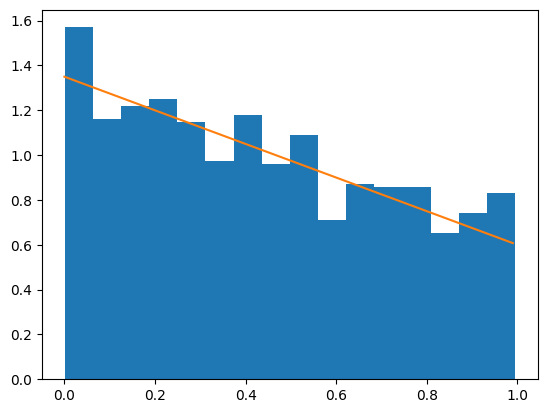

In [14]:
# Estimativa de precision e recall a partir dos fits da densidade de dados e fração de positivos:

def rho(score):
    # Fit linear da densidade feito no olho:
    return 1.35 - 0.75 * score

def f(score):
    # Fit linear da fração, valores retornados pela função af.plot_tweets_correspondence abaixo:
    return 0.07 + 0.758 * score

thres = np.arange(0, 1, 0.01)
prec = af.f_to_precision(thres, rho(thres), f(thres))
rec  = af.f_to_recall(thres, rho(thres), f(thres))

pl.hist(test_df['hate_score'], bins=16, density=True)
pl.plot(thres, rho(thres))
pl.show()

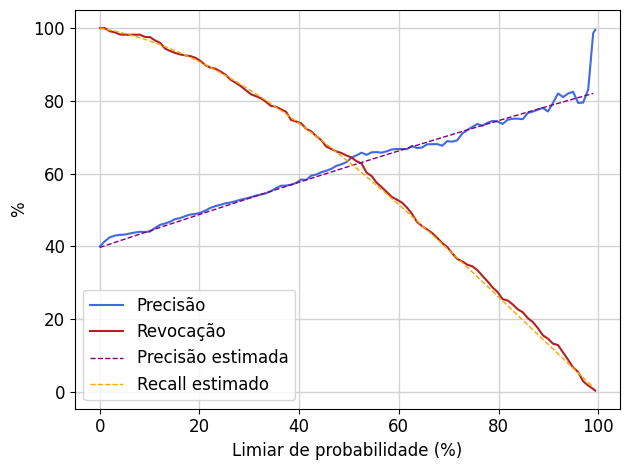

In [15]:
precision, recall, threshold = [], [], []
x = np.linspace(0, 1, 100)
for n in range(200):
    sample_df = af.sample_fixed_proportion(test_df, 'violento_final', 0.40)
    p, r, t = precision_recall_curve(sample_df['violento_final'], sample_df['hate_score'])
    precision.append(np.interp(x, t, p[:-1]))
    recall.append(np.interp(x, t, r[:-1]))
    threshold.append(np.interp(x, t, t))

threshold = np.array(threshold).mean(axis=0)
precision = np.array(precision).mean(axis=0)
recall    = np.array(recall).mean(axis=0)

pl.plot(threshold * 100, precision * 100, label='Precisão', color='royalblue')
pl.plot(threshold * 100, recall * 100, label='Revocação', color='firebrick')
pl.xlabel('Limiar de probabilidade (%)', fontsize=12)
pl.ylabel('%', fontsize=12)
pl.tick_params(labelsize=12)
pl.grid(linewidth=1, color='lightgray')
pl.tight_layout()
#pl.savefig(Path('../resultados/plots/precision-recall-curve_aplicacao-11pc.eps'))
#pl.savefig(Path('../resultados/plots/precision-recall-curve_aplicacao-11pc.png'))

pl.plot(thres * 100, prec * 100, color='purple', linestyle='--', linewidth=1, label='Precisão estimada')
pl.plot(thres * 100, rec * 100, color='orange', linestyle='--', linewidth=1, label='Recall estimado')

pl.legend(fontsize=12)

pl.show()

In [16]:
orig_density_df = pd.read_csv(Path('../dados/processados/dens_eletweets100+_por_score.csv'))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


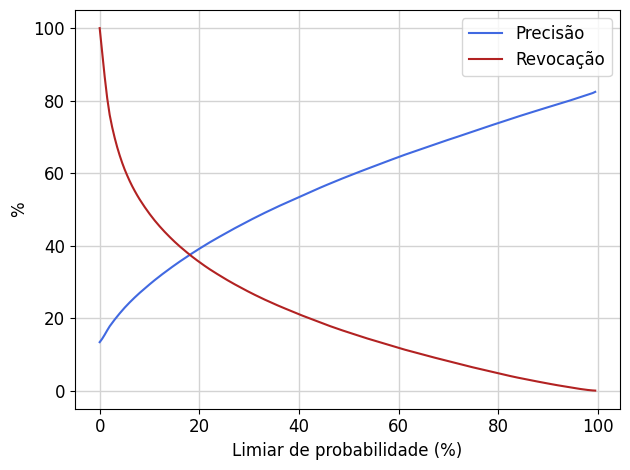

In [18]:
x = orig_density_df['hate_score'].values
precision_est = af.f_to_precision(x, orig_density_df['tweet_density'].values, f(x))
recall_est    = af.f_to_recall(x, orig_density_df['tweet_density'].values, f(x))

pl.plot(x * 100, precision_est * 100, color='royalblue', label='Precisão')
pl.plot(x * 100, recall_est * 100, color='firebrick', label='Revocação')
pl.legend(fontsize=12)
pl.xlabel('Limiar de probabilidade (%)', fontsize=12)
pl.ylabel('%', fontsize=12)
pl.tick_params(labelsize=12)
pl.grid(linewidth=1, color='lightgray')
pl.tight_layout()

#pl.savefig(Path('../resultados/plots/prec-recall_estimada-producao.eps'))
#pl.savefig(Path('../resultados/plots/prec-recall_estimada-producao.png'))

pl.show()

In [30]:
test_df['cand_objeto_final'].mean()

0.523508137432188

In [31]:
len(test_df)

1106

### Desempenho geral

In [17]:
# Fração estimada de tweets violentos:
test_df['hate_score'].mean()

0.4373715236757052

In [18]:
# Fração dos tweets que foram anotados como violentos:
test_df['violento_final'].mean()

0.4023508137432188

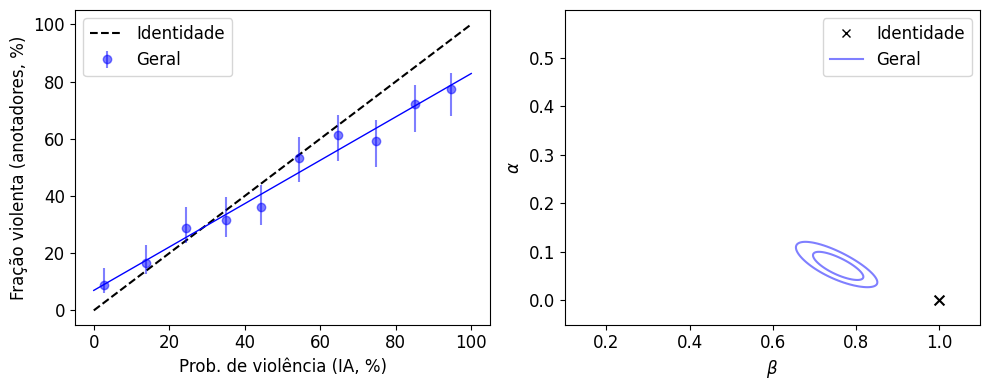

In [19]:
pl.figure(figsize=(10,4))

pl.subplot(1,2,1)
pl.plot([0,100], [0,100], linestyle='--', color='k', label='Identidade')

a, b = af.plot_tweets_correspondence(tweets_annotated_df.query('controle == 0'), 'Geral', 'b')
#a, b = af.plot_tweets_correspondence(af.sample_fixed_proportion(tweets_annotated_df.query('controle == 0'), 'violento_final', 0.60), 'Geral', 'b')

pl.subplot(1,2,1)
pl.xlabel('Prob. de violência (IA, %)', fontsize=12)
pl.ylabel('Fração violenta (anotadores, %)', fontsize=12)
pl.legend(fontsize=12)
pl.tick_params(labelsize=12)

pl.subplot(1,2,2)
pl.xlabel(r'$\beta$',fontsize=12)
pl.ylabel(r'$\alpha$',fontsize=12)
pl.tick_params(labelsize=12)
pl.scatter([1.0], [0.0], c='k', s=50, marker='x')

contline = mlines.Line2D([], [], color='b', markersize=15, label='Geral', alpha=0.5)
cross    = mlines.Line2D([], [], color='k', marker='x', markersize=6, label='Identidade', linestyle='none')
pl.legend(handles=[cross, contline], fontsize=12)

pl.tight_layout()

#pl.savefig(Path('../resultados/plots/ajuste-linear_prob-violencia_geral.svg'))
#pl.savefig(Path('../resultados/plots/ajuste-linear_prob-violencia_geral.png'))
pl.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


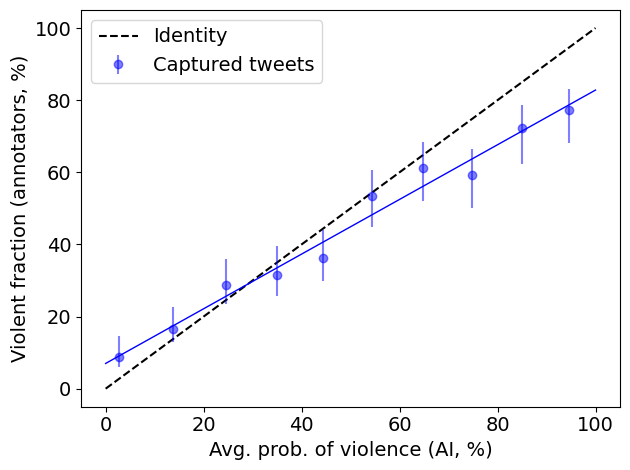

In [27]:
# Plot for paper in English:
stats_df = af.annotations_to_stats(tweets_annotated_df.query('controle == 0'))
pl.plot([0,100], [0,100], linestyle='--', color='k', label='Identity')
af.plot_score_correspondence(stats_df, a, b, 'Captured tweets', 'b')
pl.xlabel('Avg. prob. of violence (AI, %)', fontsize=14)
pl.ylabel('Violent fraction (annotators, %)', fontsize=14)
pl.legend(fontsize=14)
pl.tick_params(labelsize=14)
pl.tight_layout()
#pl.savefig(Path('../resultados/plots/ajuste-linear_prob-violencia_geral_EN.eps'))

### Desempenho vs. objeto do comentário

### Diferentes grupos com um mesmo anotador

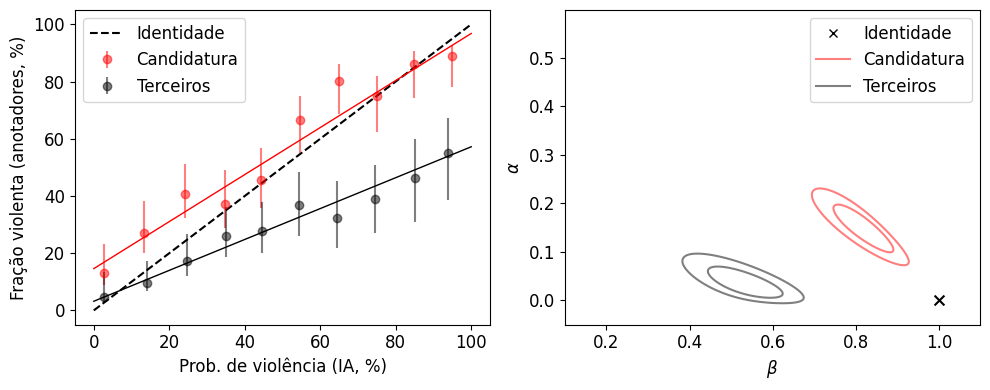

In [34]:
pl.figure(figsize=(10,4))

pl.subplot(1,2,1)
pl.plot([0,100], [0,100], linestyle='--', color='k', label='Identidade')

af.plot_tweets_correspondence(tweets_annotated_df.query('cand_objeto_final == 1 and controle == 0'), 'Candidatura', 'r')
af.plot_tweets_correspondence(tweets_annotated_df.query('cand_objeto_final == 0 and controle == 0'), 'Terceiros', 'k')

pl.subplot(1,2,1)
pl.xlabel('Prob. de violência (IA, %)', fontsize=12)
pl.ylabel('Fração violenta (anotadores, %)', fontsize=12)
pl.legend(fontsize=12)
pl.tick_params(labelsize=12)

pl.subplot(1,2,2)
pl.xlabel(r'$\beta$',fontsize=12)
pl.ylabel(r'$\alpha$',fontsize=12)
pl.tick_params(labelsize=12)
pl.scatter([1.0], [0.0], c='k', s=50, marker='x')

cross    = mlines.Line2D([], [], color='k', marker='x', markersize=6, label='Identidade', linestyle='none')
contline1 = mlines.Line2D([], [], color='r', markersize=15, label='Candidatura', alpha=0.5)
contline2 = mlines.Line2D([], [], color='k', markersize=15, label='Terceiros', alpha=0.5)
pl.legend(handles=[cross, contline1, contline2], fontsize=12)

pl.tight_layout()

#pl.savefig(Path('../resultados/plots/ajuste-linear_prob-violencia_objeto.svg'))
#pl.savefig(Path('../resultados/plots/ajuste-linear_prob-violencia_objeto.png'))
pl.show()

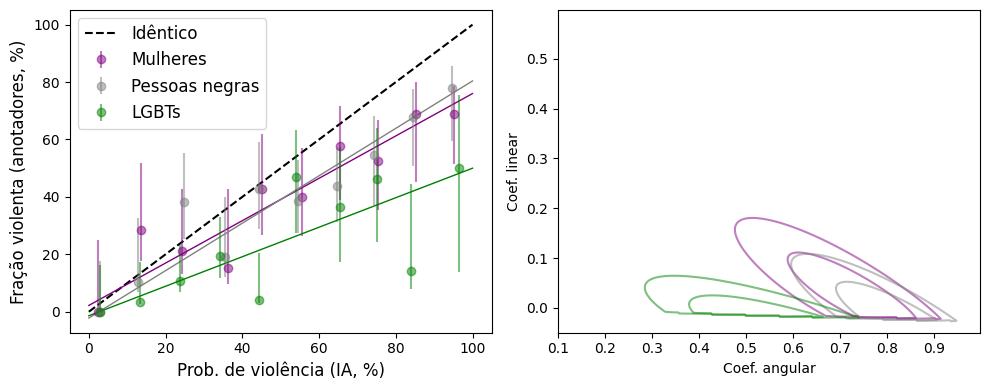

In [39]:
pl.figure(figsize=(10,4))

pl.subplot(1,2,1)
pl.plot([0,100], [0,100], linestyle='--', color='k', label='Idêntico')

a = 'A06'
af.plot_tweets_correspondence(tweets_annotated_df.loc[~tweets_annotated_df['violento_' + a].isnull() & (tweets_annotated_df['cand_objeto_final'] == 1)], 'Mulheres', 'purple', final_suffix='_' + a)
a = 'A13'
af.plot_tweets_correspondence(tweets_annotated_df.loc[~tweets_annotated_df['violento_' + a].isnull() & (tweets_annotated_df['cand_objeto_final'] == 1)], 'Pessoas negras', 'gray', final_suffix='_' + a)
a = 'A09'
af.plot_tweets_correspondence(tweets_annotated_df.loc[~tweets_annotated_df['violento_' + a].isnull() & (tweets_annotated_df['cand_objeto_final'] == 1)], 'LGBTs', 'green', final_suffix='_' + a)

pl.subplot(1,2,1)
pl.xlabel('Prob. de violência (IA, %)', fontsize=12)
pl.ylabel('Fração violenta (anotadores, %)', fontsize=12)
pl.legend(fontsize=12)

pl.subplot(1,2,2)
pl.xlabel('Coef. angular')
pl.ylabel('Coef. linear')

pl.tight_layout()
pl.show()

### Cada grupo com 3 anotadores

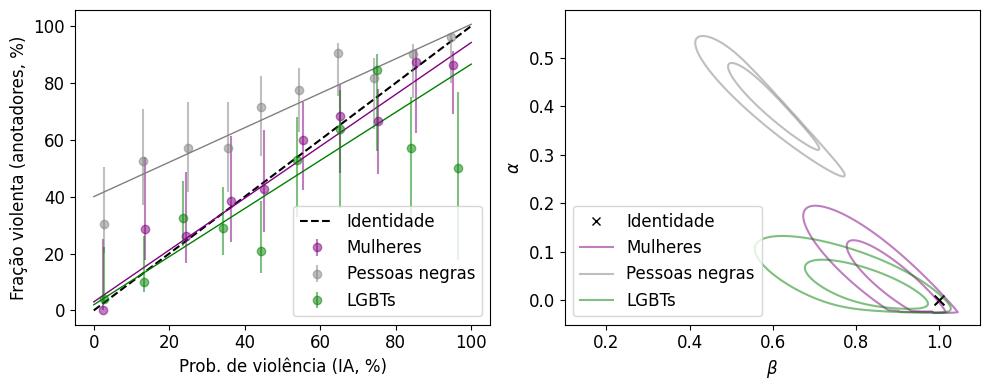

In [30]:
pl.figure(figsize=(10,4))

pl.subplot(1,2,1)
pl.plot([0,100], [0,100], linestyle='--', color='k', label='Identidade')

af.plot_tweets_correspondence(tweets_annotated_df.query('mulheres == 1 and cand_objeto_final == 1'), 'Mulheres', 'purple')
af.plot_tweets_correspondence(tweets_annotated_df.query('pessoas_negras == 1 and cand_objeto_final == 1'), 'Pessoas negras', 'gray')
af.plot_tweets_correspondence(tweets_annotated_df.query('lgbts == 1 and cand_objeto_final == 1'), 'LGBTs', 'green')

pl.subplot(1,2,1)
pl.xlabel('Prob. de violência (IA, %)', fontsize=12)
pl.ylabel('Fração violenta (anotadores, %)', fontsize=12)
pl.legend(fontsize=12)
pl.tick_params(labelsize=12)

pl.subplot(1,2,2)
pl.xlabel(r'$\beta$',fontsize=12)
pl.ylabel(r'$\alpha$',fontsize=12)
pl.tick_params(labelsize=12)
pl.scatter([1.0], [0.0], c='k', s=50, marker='x')

cross    = mlines.Line2D([], [], color='k', marker='x', markersize=6, label='Identidade', linestyle='none')
contline1 = mlines.Line2D([], [], color='purple', markersize=15, label='Mulheres', alpha=0.5)
contline2 = mlines.Line2D([], [], color='gray', markersize=15, label='Pessoas negras', alpha=0.5)
contline3 = mlines.Line2D([], [], color='green', markersize=15, label='LGBTs', alpha=0.5)
pl.legend(handles=[cross, contline1, contline2, contline3], fontsize=12, loc='lower left')

pl.tight_layout()

#pl.savefig(Path('../resultados/plots/ajuste-linear_prob-violencia_grupo-social.svg'))
#pl.savefig(Path('../resultados/plots/ajuste-linear_prob-violencia_grupo-social.png'))
pl.show()

In [23]:
# Tweets direcionado a candidaturas negras anotados como violentos e rankeados como não violentos pela IA:
xd.print_string_series(tweets_annotated_df.query('pessoas_negras == 1 and cand_objeto_final == 1 and violento_final == 1 and hate_score < 0.2').set_index('tweet_url')['text'])

https://www.twitter.com/CillerTavares/status/1561346219045261315: @guimaraes13PT @ricardostuckert O Homem chamado capitão cueca  volta a atacar.
https://www.twitter.com/Carlinhosclube/status/1564253251998031873: @jfernandaBrasil Tá loka?
https://www.twitter.com/lukinha360games/status/1564440907755167744: @LeoSuricate Aí mente DEMAIS 😏
https://www.twitter.com/JosAlfredoDeTo1/status/1564625070550663168: @andremarianors KKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKK
https://www.twitter.com/MarcioBraga01/status/1564802248118501378: @tiriricanaweb Volta p circo de onde veio.. o da política já tem palhaços demais!
https://www.twitter.com/Dansouza81/status/1564917677059080200: @Eunicio Falou o picareta da empresa Manchester que ganhou um contrato de 1 bilhão da Petrobrás sem Licitação!!!!
https://www.twitter.com/rodrigokrfarias/status/1567679929168306178: @fabiofelixdf O Brasil teve um superávit nas contas públicas de R$19,3bi. Maior índice em 11 anos. E outra, inflação boa é a de 71% e 62% da Arge

### Por tipo de violência

In [35]:
tweets_annotated_df.query('controle == 0 and violento_final == 1')[['racista_final', 'machista_final', 'lgbtfobico_final']].sum()

racista_final       24.0
machista_final      97.0
lgbtfobico_final    26.0
dtype: float64

In [32]:
tweets_annotated_df.query('controle == 0 and violento_final == 1')[['racista_final', 'machista_final', 'lgbtfobico_final']].mean()

racista_final       0.053933
machista_final      0.217978
lgbtfobico_final    0.058427
dtype: float64

In [39]:
from scipy.stats import ks_2samp

In [83]:
def compare_scores_per_violence_type(tweets_df, campo, color=None):

    edges = np.arange(0, 101, 10)
    generic  = tweets_df.query('violento_final == 1 and racista_final == 0 and machista_final == 0 and lgbtfobico_final == 0' )['hate_score'] * 100
    specific = tweets_df.query(campo + '_final == 1 and violento_final == 1')['hate_score'] * 100
    ks = ks_2samp(generic, specific)

    ax = pl.gca()
    pl.text(0.02, 0.8, 'Valor-$p$ (KS): {:.1f}%'.format(ks.pvalue * 100), transform=ax.transAxes, ha='left', va='top', fontsize=12)
    xp.errorbar_hist(specific, bins=edges, alpha=0.4, color=color, density=True, label=campo.replace('_', ' ').capitalize(), rwidth=0.95)
    xp.errorbar_hist(generic, bins=edges, alpha=0.4, color='gray', density=True, label='Genérico', rwidth=0.95)

    pl.xlabel('Prob. de violência (IA, %)', fontsize=12)
    pl.legend(loc='upper left', fontsize=12)
    #pl.title('Nota da IA para comentários violentos, por tipo')

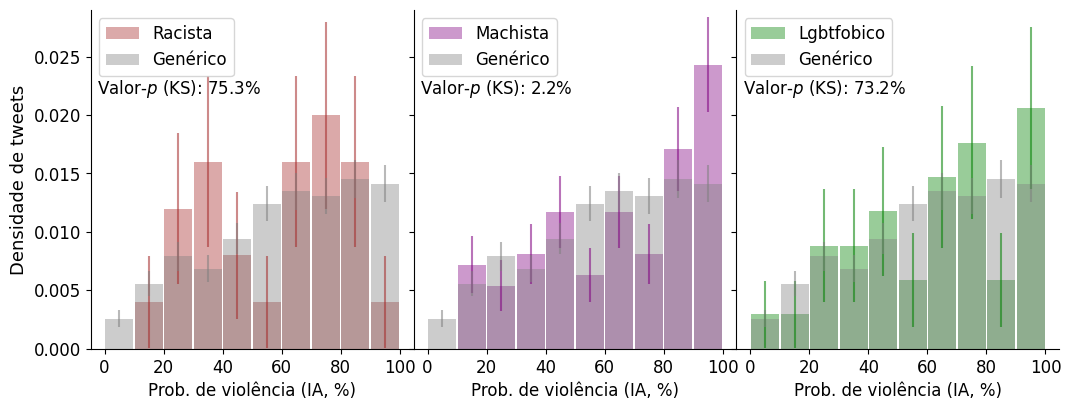

In [91]:
pl.figure(figsize=(12.5, 4.4))
for i, campo, cor in zip([1, 2, 3], ['racista', 'machista', 'lgbtfobico'], ['brown', 'purple', 'g']):
    pl.subplot(1, 3, i)
    compare_scores_per_violence_type(tweets_annotated_df, campo, cor)
    pl.ylim([0, 0.029])
    
    pl.tick_params(labelsize=12)
    ax = pl.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    if i > 1:
        #pl.yticks([])
        #ax.spines['left'].set_visible(False)
        ax.axes.yaxis.set_ticklabels([])
    else:
        pl.ylabel('Densidade de tweets', fontsize=13)

pl.subplots_adjust(wspace=0)
#pl.savefig(Path('../resultados/plots/hist_score-por-tipo.svg'), bbox_inches='tight')
#pl.savefig(Path('../resultados/plots/hist_score-por-tipo.png'), bbox_inches='tight')
pl.show()

### Erros do modelo

In [69]:
newnames = {'text': 'Texto com rótulo final de não-violento', 'hate_score': 'Score'}
fp_df = tweets_annotated_df.query('controle == 0 and violento_final == 0').sort_values('hate_score').tail(10)[['text', 'hate_score']]
ids = pd.Series(np.arange(1, len(fp_df) + 1), dtype=int, name='ID')
fp_df = fp_df.rename(newnames, axis=1)#.set_index(ids, drop=True)
fp_df
#fp_df.to_csv(Path('../resultados/erros_tweets_falsos-positivos.csv'))

,Texto com rótulo final de não-violento,Score
455,@CarinaBelome Esse povo é safado até o ultimo,0.938491
299,@Zambelli2210 Vagabundo,0.939317
372,@ValeriaBnews Traidora nojenta,0.946588
1267,@caroldartora13 Covarde e bundão como todo bol...,0.948944
1410,@ErikakHilton que gata da porra,0.960220
1491,@joicehasselmann Sai pra lá sua oportunista tr...,0.965421
895,@juujuferrari Gostosa juju,0.969009
1248,@jandira_feghali Bandido! Safado,0.977099
744,@JulianaBrizola Ele virou chuchuca do bozo,0.979481
1216,@CarolDeToni Toma safada,0.984331


In [67]:
newnames = {'text': 'Texto com rótulo final de violento', 'hate_score': 'Score'}
fn_df = tweets_annotated_df.query('controle == 0 and violento_final == 1').sort_values('hate_score').head(10)[['text', 'hate_score']]
ids = pd.Series(np.arange(1, len(fn_df) + 1), dtype=int, name='ID')
fn_df = fn_df.rename(newnames, axis=1)#.set_index(ids, drop=True)
fn_df
#fn_df.to_csv(Path('../resultados/erros_tweets_falsos-negativos.csv'))

,Texto com rótulo final de violento,Score
1051,@marcosbrazrio Ganhamos o sorteio? Apaga isso ...,0.012704
1071,@AlanLopesRio É @reinaldoazevedo @GugaNoblat @...,0.013490
1338,@AriadnaArantes @LulaOficial Quem é esse???,0.015862
1489,@pastorhenriquev L de LEGIÃO https://t.co/0mrY...,0.019859
1034,@gabysantospdt @Sen_Cristovam Um eleitor lixo....,0.023702
498,@tiriricanaweb Volta p circo de onde veio.. o ...,0.030544
764,@fabiofelixdf O Brasil teve um superávit nas c...,0.031974
532,"@orlandosilva Néh... hipocrisia, sabemos quem...",0.037796
1487,@vivireispsol Lacrolandia tu vai ser DEMITIDA ...,0.080925
823,@TandaraCaixeta Tu é tão deplorável que a Fabi...,0.087384


In [79]:
tweets_annotated_df.query('controle == 0')['violento_final'].mean()

0.4023508137432188

In [75]:
tweets_annotated_df.loc[895, 'tweet_url']

'https://www.twitter.com/Raimund97859836/status/1569744554630283264'

### Escala de violência

In [13]:
test_df = tweets_annotated_df.query('controle == 0')
scale_df = test_df.groupby(af.bin_prob(test_df['hate_score'], 0.1)).sample(3).sort_values('hate_score')
xd.print_string_series(scale_df.set_index('hate_score')['text'])

0.004766899: @RobeyonceLima Boa tarde🌹🌹🌹 Amada, me indique 1 candidato a Dep. Estadual e um Senador???
Presidente, Governador e Dep. Federal (5000) eu já tenho.
😘😘
Obrigado!!
0.012264683: Meu compromisso com @bellagoncalvs pra deputada Estadual em seu voto? Tem algo errado aí…🤔
0.03244818: @bellagoncalvs A mulher fez defesa do agronegócio, falou do MST, o combo completo e a cor do sapato é o que importa?
0.14262912: @jfernandaBrasil Tá loka?
0.1630831: @renatasouzario Kkkkk vai lá defensora dos traficantes fracos e oprimidos
0.18367282: @perpetua_acre Que tolice
0.20082115: @gabysantospdt Pra cima deles, Gabi.
0.20593633: @AriadnaArantes @LulaOficial kkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkk(estude)
0.2474989: @Izalourenca Zema sim
0.32397065: @danimontpsol Votar nessa corja de abutres, esquerda maldita nunca, não vote nessa corja.
0.3360351: @bellagoncalvs Só absurdo! Sabia que ele cancelou a agenda de um evento de cultura no Palácio das Artes par

# Lixo

## Ajuste com violências específicas

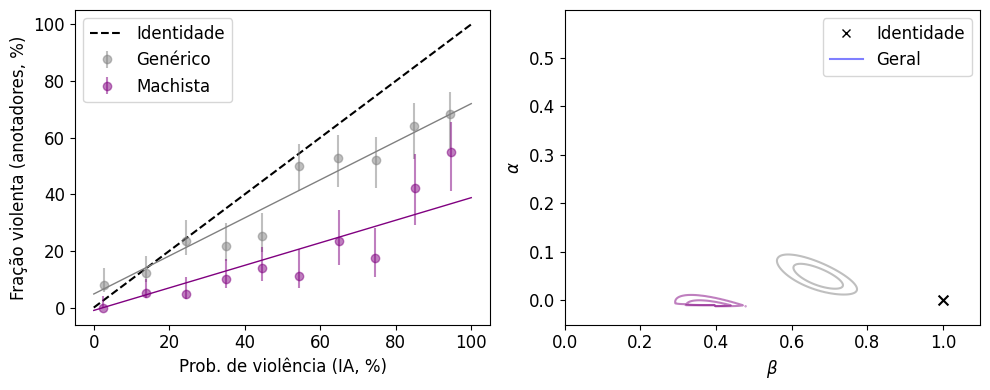

In [32]:
pl.figure(figsize=(10,4))

pl.subplot(1,2,1)
pl.plot([0,100], [0,100], linestyle='--', color='k', label='Identidade')

af.plot_tweets_correspondence(tweets_annotated_df.query('controle == 0 and racista_final == 0 and machista_final == 0 and lgbtfobico_final == 0'), 'Genérico', 'gray')
af.plot_tweets_correspondence(tweets_annotated_df.query('controle == 0 and (violento_final == 0 or machista_final == 1)'), 'Machista', 'purple')
#af.plot_tweets_correspondence(tweets_annotated_df.query('controle == 0 and (violento_final == 0 or racista_final == 1)'), 'Racista', 'r')
#af.plot_tweets_correspondence(tweets_annotated_df.query('controle == 0 and (violento_final == 0 or lgbtfobico_final == 1)'), 'LGBTfobico', 'green')

pl.subplot(1,2,1)
pl.xlabel('Prob. de violência (IA, %)', fontsize=12)
pl.ylabel('Fração violenta (anotadores, %)', fontsize=12)
pl.legend(fontsize=12)
pl.tick_params(labelsize=12)

pl.subplot(1,2,2)
pl.xlabel(r'$\beta$',fontsize=12)
pl.ylabel(r'$\alpha$',fontsize=12)
pl.tick_params(labelsize=12)
pl.scatter([1.0], [0.0], c='k', s=50, marker='x')

contline = mlines.Line2D([], [], color='b', markersize=15, label='Geral', alpha=0.5)
cross    = mlines.Line2D([], [], color='k', marker='x', markersize=6, label='Identidade', linestyle='none')
pl.legend(handles=[cross, contline], fontsize=12)

pl.tight_layout()

#pl.savefig(Path('../resultados/plots/ajuste-linear_prob-violencia_geral.svg'))
#pl.savefig(Path('../resultados/plots/ajuste-linear_prob-violencia_geral.png'))
pl.show()

## Estimativa de densidade

Está errada, densidade linear dá valor negativo, entre outros.

In [76]:
def linear_density(x, *args):
    
    # Compute area under line, assuming x in [0,1]:
    side0 = args[0]
    side1 = args[0] + args[1]
    area  = (side0 + side1) / 2
    
    return (args[0] + args[1] * x) / area

def independent_likelihood(prob_func, x, *args):
        
    L = prob_func(x, *args).prod()
    return L

def linear_dens_likelihood(x, a, b):
    return independent_likelihood(linear_density, x, a, b)

In [78]:
from multiprocessing import Pool
from itertools import repeat

In [116]:
# Build grid of coordinates:
x = test_df['hate_score']
amin = 0
amax = 2
da   = 0.01
bmin = -1
bmax = 0
db   = 0.01
aa, bb = np.mgrid[amin:amax:da, bmin:bmax:db]

# Map likelihood:
with Pool() as pool:
    L = np.clip(pool.starmap(linear_dens_likelihood, zip(repeat(x), aa.ravel(), bb.ravel())), 0, np.inf)
L = L.reshape(aa.shape)

# Map posterior:
Post = L
Post = Post / (Post.sum() * da * db)

/tmp/ipykernel_2742/2134889733.py:18: RuntimeWarning: invalid value encountered in divide
  Post = Post / (Post.sum() * da * db)


## Independência da métrica com proporçãos das classes

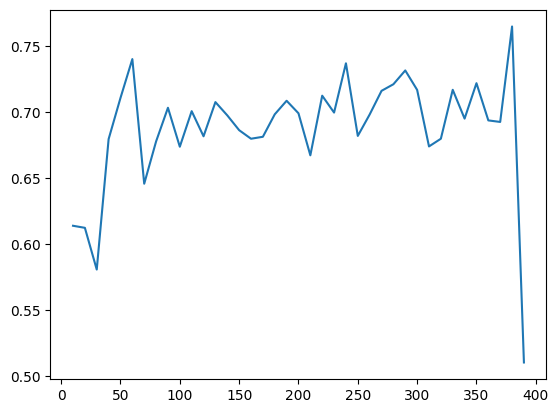

In [73]:
# Demonstrando independência da métrica com a proporção entre as categorias:
tot = 400
n = 10
x = range(10, 400, 10)
sc = []
for n in x:
    z = pd.concat([test_df.query('violento_final == 0').sample(tot - n), test_df.query('violento_final == 1').sample(n)])
    sc.append(ml.geomean_hit_rate(z['violento_final'], z['hate_score'] > 0.5))

pl.plot(x, sc)
pl.show()